## Classification experiment - Dmoz Computers

This week we have 3 delivarables:
- A `.py` file that finds the best model's hyperparameters;
- The `.csv` file with best hyperparameters finded;
- A `.ipynb` file that shows the best hyperparameters finded and the final metrics for the text classification experiment.

This notebook aims to find the best model to compete against MultinomialNB and LogisticRegression - models selected by the professor. The data used here is available in the [Text Collections](https://github.com/ragero/text-collections/tree/master/complete_texts_csvs) Github repo. I chose an arbitrary dataset for this first experiment.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

### Data

In [3]:
df = pd.read_csv("text_databases/Dmoz-Computers.csv")
df

,file_name,text,class
0,Intelligence_1434272.txt,Principal Curves Page Introduction to principa...,Artificial
1,Intelligence_1433615.txt,Iowa State University - Artificial Intelligenc...,Artificial
2,Intelligence_1434400.txt,"Paccanaro, Alberto Learning distributed repres...",Artificial
3,Intelligence_1434281.txt,Attrasoft Provider of a number of neural netwo...,Artificial
4,Intelligence_1434141.txt,LibML A machine learning library. New implemen...,Artificial
...,...,...,...
9495,1533704.txt,Palm V and Linux Pointers on using a Palm unde...,Systems
9496,1533680.txt,PalmPilot Pong The classic ball and bat game. ...,Systems
9497,1532282.txt,PitViper009's House of Programming PitViper009...,Systems
9498,1532640.txt,Roughly Drafted Magazine Weblog by Daniel Eran...,Systems


In [4]:
df.fillna('', inplace=True)
df

,file_name,text,class
0,Intelligence_1434272.txt,Principal Curves Page Introduction to principa...,Artificial
1,Intelligence_1433615.txt,Iowa State University - Artificial Intelligenc...,Artificial
2,Intelligence_1434400.txt,"Paccanaro, Alberto Learning distributed repres...",Artificial
3,Intelligence_1434281.txt,Attrasoft Provider of a number of neural netwo...,Artificial
4,Intelligence_1434141.txt,LibML A machine learning library. New implemen...,Artificial
...,...,...,...
9495,1533704.txt,Palm V and Linux Pointers on using a Palm unde...,Systems
9496,1533680.txt,PalmPilot Pong The classic ball and bat game. ...,Systems
9497,1532282.txt,PitViper009's House of Programming PitViper009...,Systems
9498,1532640.txt,Roughly Drafted Magazine Weblog by Daniel Eran...,Systems


### Model exploration

I made some helper functions to quickly retrieve me a text classification experiment:
- In the folder `utils`, we have two functions:
    - `custom_cls`: fits a given model or pipeline and keeps track of performance metrics and elapsed time;
    - `get_cls_results`: a function that calls `custom_cls` and prints the metrics of the current using classification_report and a confusion matrix.

I also made some preprocessing transformers. All classes inherit from sklearn `TransformerMixin` and `BaseEstimator`. We have transformers for removing stopwords, for stemming, and also for lemmatization.

In [5]:
from preprocessing import StopwordsTransformer, StemmerTransformer, LemmatizerTransformer
from utils import get_cls_results

I usually choose a model for each 'category' of models:
- SVC is often a good baseline, both using the RBF and the linear kernels;
- A DecisionTree is also a good baseline for tree methods;
- Ensemble methods are also useful, so getting XGBoost or LightGBM is also a nice starting point;
- For linear methods, I generally took the LogisticRegression, but as this model is one the choices for the final experiment I got the RidgeClassifier instead.

To vectorize the text, I use the main Bag of Words methods available in sklearn:
- CountVectorizer
- TF-IDF
- HashingVectorizer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier

In [7]:
# LGBM asks for float values, default of CountVectorizer is int64
cv_vec = CountVectorizer(dtype=np.float64)
tfidf_vec = TfidfVectorizer()
hash_vec = HashingVectorizer()

svc_model = SVC(random_state=14)
svc_linear_model = SVC(kernel='linear', max_iter=10000, random_state=14)
# lgbm talks a bit too much; verbose=-1 suppresses most of it
lgbm = LGBMClassifier(objective="multiclass", verbose=-1, random_state=14)
dt_model = DecisionTreeClassifier(random_state=14)
ridge = RidgeClassifier(random_state=14)

In [8]:
models_reprs = {
    'models': [svc_model, svc_linear_model, lgbm, dt_model, ridge],
    'vectorizers': [cv_vec, tfidf_vec, hash_vec]
}

The helper function `custom_cls`, called within the function `get_cls_results`, receives a dataframe like this one below to track the models' scores.

In [9]:
results = pd.DataFrame(columns=['Precision', 'Recall', 'F1-Score', 'Time elapsed'])

Split made according the given exercise instructions, using a 80-20 ratio for train and test data.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'],
                                                    test_size=0.2, random_state=14,
                                                    stratify=df['class'])

split_data = [X_train, X_test, y_train, y_test]

### Classification without preprocessing steps

In [11]:
from sklearn.pipeline import Pipeline
import time

SVC(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)


/home/user/unb/unb_mestrado/2_semestre/topicos_nlp/nlp/atividade_3/utils.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([results, row])


              precision    recall  f1-score   support

  Artificial       0.80      0.57      0.67       100
         CAD       0.83      0.69      0.75       100
   Companies       0.60      0.64      0.62       100
    Computer       0.78      0.78      0.78       100
 Consultants       0.59      0.67      0.63       100
        Data       0.41      0.81      0.54       200
   Education       0.89      0.80      0.84       100
    Graphics       0.84      0.83      0.83       100
    Hardware       0.64      0.56      0.60       100
    Internet       0.81      0.61      0.70       100
      Mobile       0.90      0.70      0.79       100
  Multimedia       0.77      0.54      0.64       100
        Open       0.64      0.70      0.67       100
 Programming       0.50      0.42      0.46       100
    Robotics       0.93      0.80      0.86       100
    Security       0.79      0.44      0.56       100
    Software       0.24      0.20      0.22       100
     Systems       0.50    

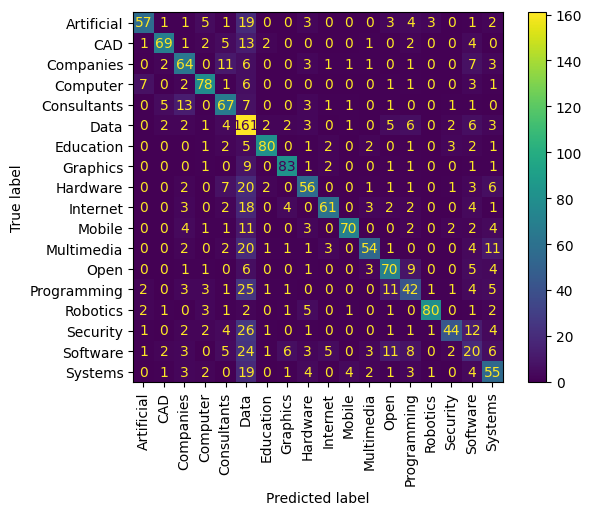

--- 14.105441808700562 seconds ---
SVC(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

  Artificial       0.86      0.68      0.76       100
         CAD       0.89      0.72      0.80       100
   Companies       0.63      0.73      0.68       100
    Computer       0.79      0.81      0.80       100
 Consultants       0.62      0.66      0.64       100
        Data       0.44      0.85      0.58       200
   Education       0.90      0.81      0.85       100
    Graphics       0.90      0.86      0.88       100
    Hardware       0.74      0.61      0.67       100
    Internet       0.88      0.57      0.69       100
      Mobile       0.91      0.72      0.80       100
  Multimedia       0.79      0.63      0.70       100
        Open       0.63      0.68      0.65       100
 Programming       0.52      0.44      0.48       100
    Robotics       0.96      0.87      0.91       100
    Security       0.78      0.58      0.67       100
    Sof

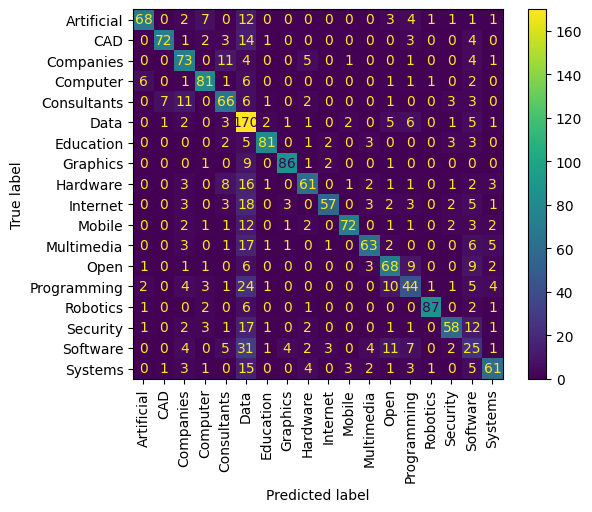

--- 16.06747579574585 seconds ---
SVC(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

  Artificial       0.84      0.63      0.72       100
         CAD       0.86      0.68      0.76       100
   Companies       0.58      0.66      0.62       100
    Computer       0.82      0.80      0.81       100
 Consultants       0.60      0.65      0.62       100
        Data       0.41      0.81      0.55       200
   Education       0.89      0.79      0.84       100
    Graphics       0.86      0.84      0.85       100
    Hardware       0.74      0.56      0.64       100
    Internet       0.81      0.63      0.71       100
      Mobile       0.91      0.68      0.78       100
  Multimedia       0.80      0.52      0.63       100
        Open       0.64      0.68      0.66       100
 Programming       0.48      0.47      0.47       100
    Robotics       0.95      0.83      0.89       100
    Security       0.80      0.47      0.59       100
    So

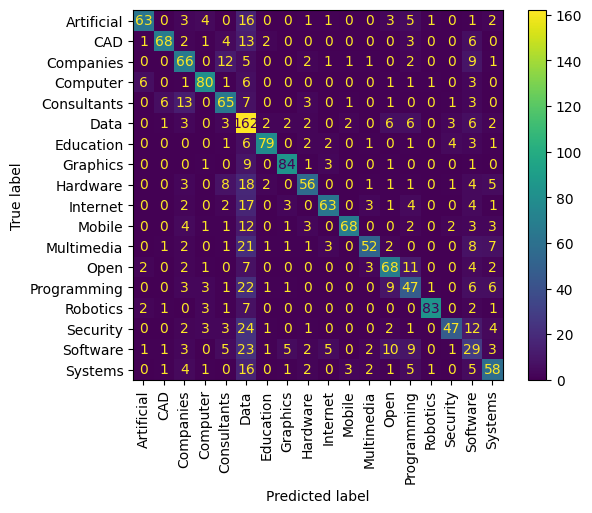

--- 14.7748281955719 seconds ---
SVC(kernel='linear', max_iter=10000, random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

  Artificial       0.76      0.70      0.73       100
         CAD       0.80      0.79      0.79       100
   Companies       0.49      0.64      0.55       100
    Computer       0.77      0.74      0.76       100
 Consultants       0.56      0.63      0.59       100
        Data       0.68      0.71      0.69       200
   Education       0.85      0.85      0.85       100
    Graphics       0.89      0.86      0.87       100
    Hardware       0.64      0.66      0.65       100
    Internet       0.65      0.64      0.64       100
      Mobile       0.82      0.76      0.79       100
  Multimedia       0.67      0.63      0.65       100
        Open       0.63      0.68      0.65       100
 Programming       0.50      0.49      0.49       100
    Robotics       0.92      0.87      0.89       100
 

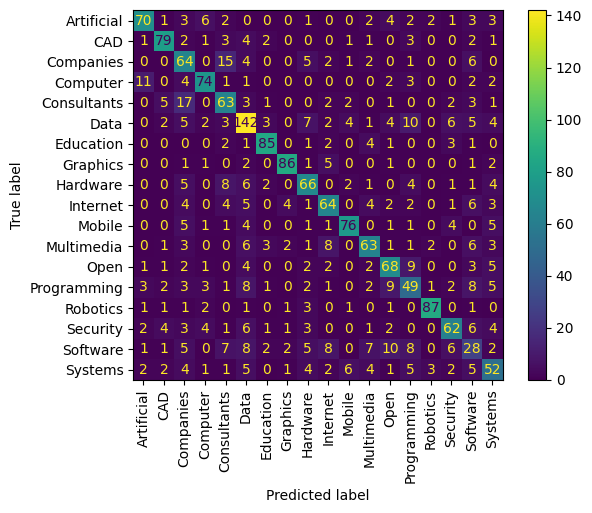

--- 9.545352697372437 seconds ---
SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

  Artificial       0.84      0.72      0.77       100
         CAD       0.87      0.79      0.83       100
   Companies       0.60      0.71      0.65       100
    Computer       0.81      0.83      0.82       100
 Consultants       0.62      0.70      0.66       100
        Data       0.70      0.78      0.74       200
   Education       0.90      0.85      0.88       100
    Graphics       0.90      0.90      0.90       100
    Hardware       0.73      0.65      0.69       100
    Internet       0.78      0.63      0.70       100
      Mobile       0.89      0.76      0.82       100
  Multimedia       0.73      0.73      0.73       100
        Open       0.61      0.70      0.65       100
 Programming       0.48      0.53      0.50       100
    Robotics       0.96      0.90      0.93       100
    Security       0.79      

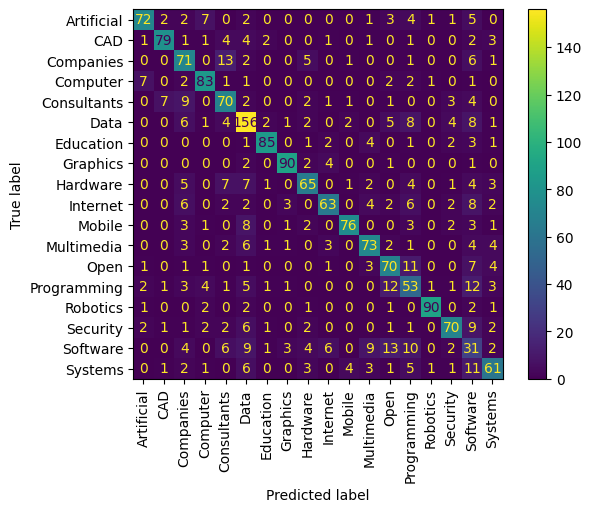

--- 15.750436067581177 seconds ---
SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

  Artificial       0.85      0.70      0.77       100
         CAD       0.82      0.75      0.79       100
   Companies       0.58      0.70      0.63       100
    Computer       0.79      0.81      0.80       100
 Consultants       0.58      0.66      0.62       100
        Data       0.61      0.76      0.68       200
   Education       0.90      0.82      0.86       100
    Graphics       0.87      0.85      0.86       100
    Hardware       0.74      0.61      0.67       100
    Internet       0.77      0.63      0.69       100
      Mobile       0.90      0.72      0.80       100
  Multimedia       0.76      0.61      0.68       100
        Open       0.59      0.68      0.63       100
 Programming       0.44      0.47      0.45       100
    Robotics       0.96      0.87      0.91       100
    Security       0.78   

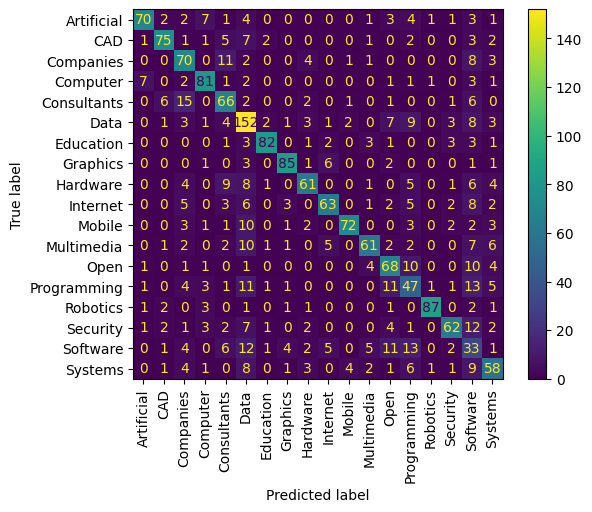

--- 12.279847383499146 seconds ---
LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

  Artificial       0.80      0.63      0.70       100
         CAD       0.80      0.69      0.74       100
   Companies       0.54      0.56      0.55       100
    Computer       0.79      0.73      0.76       100
 Consultants       0.60      0.60      0.60       100
        Data       0.58      0.68      0.63       200
   Education       0.88      0.83      0.86       100
    Graphics       0.79      0.80      0.80       100
    Hardware       0.55      0.59      0.57       100
    Internet       0.71      0.61      0.66       100
      Mobile       0.76      0.71      0.73       100
  Multimedia       0.60      0.66      0.63       100
        Open       0.57      0.62      0.60       100
 Programming       0.42      0.40      0.41       100
    Robotics       0.92      0.86      

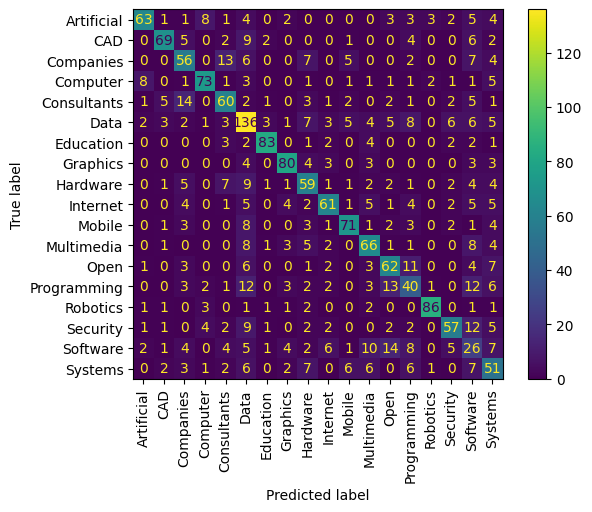

--- 4.077688932418823 seconds ---
LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) TfidfVectorizer()
              precision    recall  f1-score   support

  Artificial       0.78      0.62      0.69       100
         CAD       0.82      0.63      0.71       100
   Companies       0.54      0.62      0.58       100
    Computer       0.83      0.76      0.79       100
 Consultants       0.60      0.58      0.59       100
        Data       0.60      0.70      0.65       200
   Education       0.84      0.80      0.82       100
    Graphics       0.80      0.81      0.81       100
    Hardware       0.64      0.56      0.60       100
    Internet       0.69      0.61      0.65       100
      Mobile       0.80      0.76      0.78       100
  Multimedia       0.62      0.61      0.62       100
        Open       0.56      0.66      0.61       100
 Programming       0.41      0.38      0.39       100
    Robotics       0.91      0.85      0.88       100
    Security   

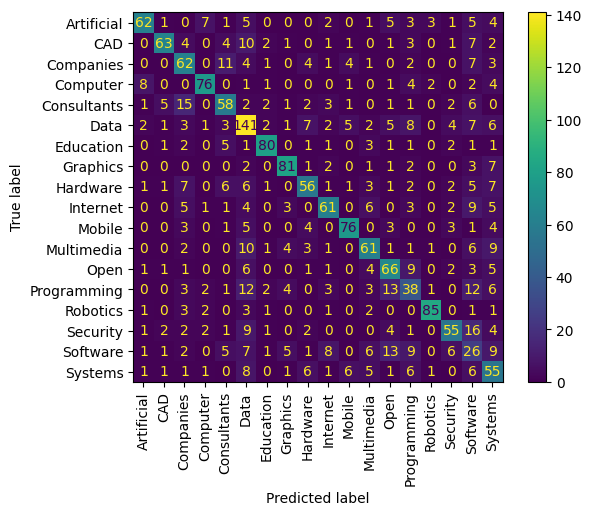

--- 9.461842775344849 seconds ---
LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) HashingVectorizer()
              precision    recall  f1-score   support

  Artificial       0.82      0.61      0.70       100
         CAD       0.81      0.65      0.72       100
   Companies       0.53      0.57      0.55       100
    Computer       0.77      0.73      0.75       100
 Consultants       0.62      0.59      0.61       100
        Data       0.54      0.71      0.61       200
   Education       0.86      0.81      0.84       100
    Graphics       0.83      0.82      0.82       100
    Hardware       0.50      0.52      0.51       100
    Internet       0.73      0.61      0.66       100
      Mobile       0.80      0.74      0.77       100
  Multimedia       0.68      0.64      0.66       100
        Open       0.58      0.65      0.61       100
 Programming       0.39      0.35      0.37       100
    Robotics       0.92      0.84      0.88       100
    Security 

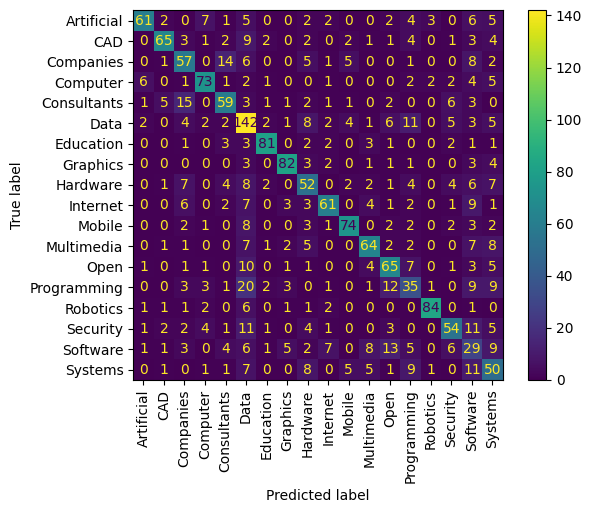

--- 11.540263414382935 seconds ---
DecisionTreeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

  Artificial       0.56      0.43      0.49       100
         CAD       0.55      0.53      0.54       100
   Companies       0.47      0.47      0.47       100
    Computer       0.65      0.64      0.65       100
 Consultants       0.42      0.45      0.43       100
        Data       0.53      0.56      0.55       200
   Education       0.76      0.65      0.70       100
    Graphics       0.66      0.75      0.70       100
    Hardware       0.38      0.46      0.42       100
    Internet       0.57      0.56      0.56       100
      Mobile       0.68      0.66      0.67       100
  Multimedia       0.51      0.42      0.46       100
        Open       0.48      0.50      0.49       100
 Programming       0.26      0.27      0.26       100
    Robotics       0.87      0.77      0.81       100
    Security 

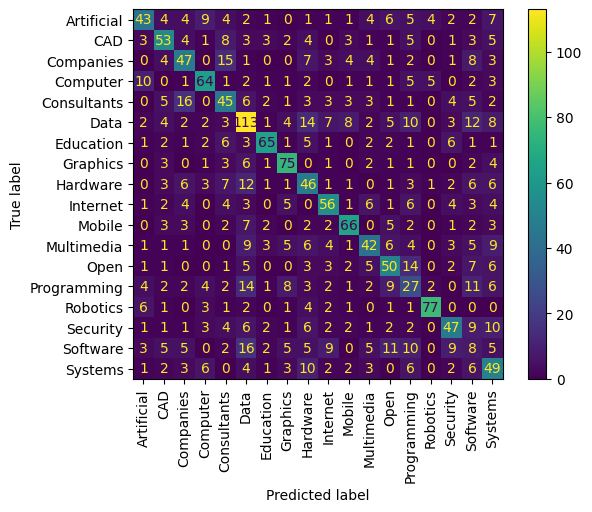

--- 2.2342865467071533 seconds ---
DecisionTreeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

  Artificial       0.49      0.40      0.44       100
         CAD       0.44      0.44      0.44       100
   Companies       0.37      0.37      0.37       100
    Computer       0.59      0.63      0.61       100
 Consultants       0.36      0.40      0.38       100
        Data       0.53      0.52      0.52       200
   Education       0.72      0.66      0.69       100
    Graphics       0.69      0.77      0.73       100
    Hardware       0.50      0.52      0.51       100
    Internet       0.50      0.51      0.50       100
      Mobile       0.75      0.63      0.68       100
  Multimedia       0.44      0.42      0.43       100
        Open       0.47      0.45      0.46       100
 Programming       0.24      0.24      0.24       100
    Robotics       0.81      0.81      0.81       100
    Security       0.54      0.51      0.5

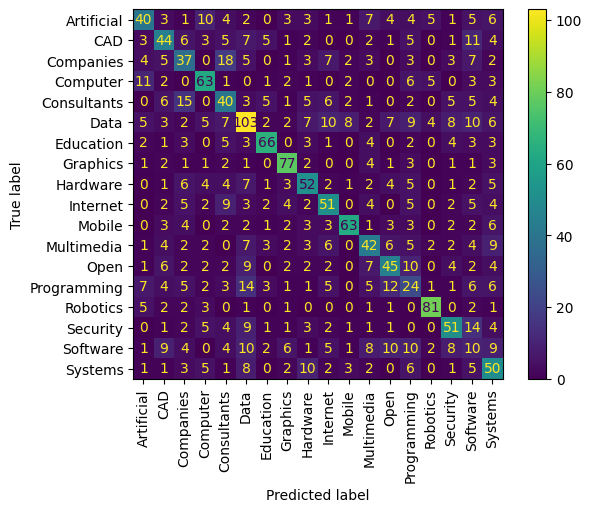

--- 2.8328373432159424 seconds ---
DecisionTreeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

  Artificial       0.59      0.52      0.55       100
         CAD       0.55      0.52      0.54       100
   Companies       0.42      0.43      0.43       100
    Computer       0.69      0.64      0.66       100
 Consultants       0.37      0.40      0.39       100
        Data       0.52      0.55      0.53       200
   Education       0.74      0.65      0.69       100
    Graphics       0.74      0.75      0.74       100
    Hardware       0.44      0.48      0.46       100
    Internet       0.50      0.52      0.51       100
      Mobile       0.73      0.66      0.69       100
  Multimedia       0.49      0.46      0.47       100
        Open       0.55      0.59      0.57       100
 Programming       0.26      0.27      0.27       100
    Robotics       0.87      0.77      0.81       100
    Security       0.53      0.39      0

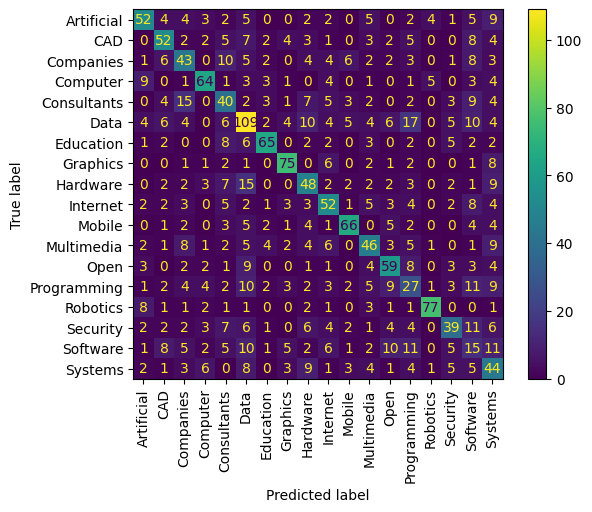

--- 26.8383309841156 seconds ---
RidgeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

  Artificial       0.82      0.69      0.75       100
         CAD       0.80      0.75      0.77       100
   Companies       0.50      0.67      0.57       100
    Computer       0.73      0.75      0.74       100
 Consultants       0.50      0.64      0.56       100
        Data       0.72      0.74      0.73       200
   Education       0.78      0.79      0.79       100
    Graphics       0.91      0.93      0.92       100
    Hardware       0.63      0.64      0.64       100
    Internet       0.74      0.61      0.67       100
      Mobile       0.79      0.77      0.78       100
  Multimedia       0.69      0.72      0.70       100
        Open       0.53      0.59      0.56       100
 Programming       0.50      0.45      0.47       100
    Robotics       0.96      0.87      0.91       100
    Security       0.7

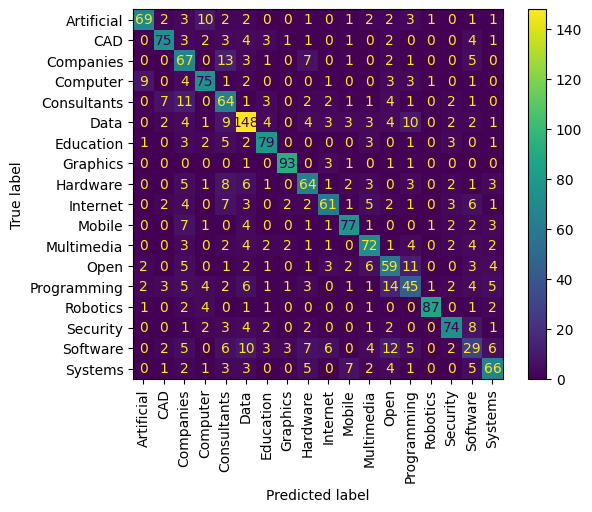

--- 13.471870183944702 seconds ---
RidgeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

  Artificial       0.84      0.74      0.79       100
         CAD       0.81      0.79      0.80       100
   Companies       0.61      0.71      0.65       100
    Computer       0.79      0.85      0.82       100
 Consultants       0.58      0.68      0.63       100
        Data       0.75      0.78      0.76       200
   Education       0.84      0.88      0.86       100
    Graphics       0.89      0.94      0.91       100
    Hardware       0.71      0.72      0.71       100
    Internet       0.80      0.63      0.70       100
      Mobile       0.80      0.78      0.79       100
  Multimedia       0.76      0.81      0.78       100
        Open       0.57      0.69      0.62       100
 Programming       0.55      0.47      0.51       100
    Robotics       0.92      0.91      0.91       100
    Security       0.77      0.79      0.78      

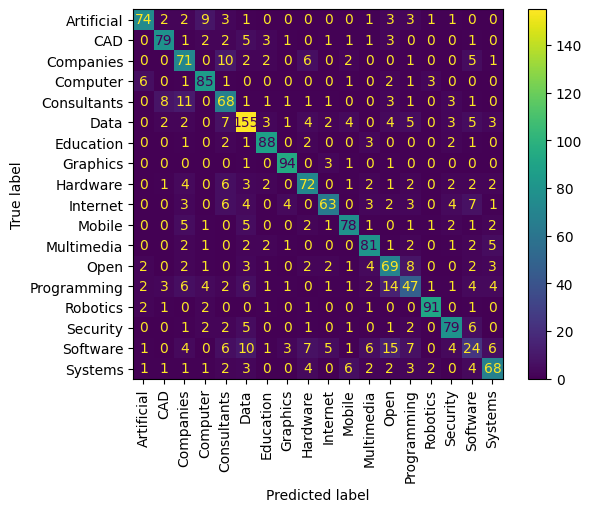

--- 3.0619559288024902 seconds ---
RidgeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

  Artificial       0.82      0.73      0.77       100
         CAD       0.78      0.82      0.80       100
   Companies       0.60      0.72      0.65       100
    Computer       0.81      0.85      0.83       100
 Consultants       0.61      0.66      0.63       100
        Data       0.73      0.79      0.76       200
   Education       0.84      0.87      0.85       100
    Graphics       0.85      0.91      0.88       100
    Hardware       0.67      0.71      0.69       100
    Internet       0.81      0.64      0.72       100
      Mobile       0.83      0.76      0.79       100
  Multimedia       0.74      0.80      0.77       100
        Open       0.58      0.69      0.63       100
 Programming       0.57      0.48      0.52       100
    Robotics       0.92      0.91      0.91       100
    Security       0.78      0.79      0.79    

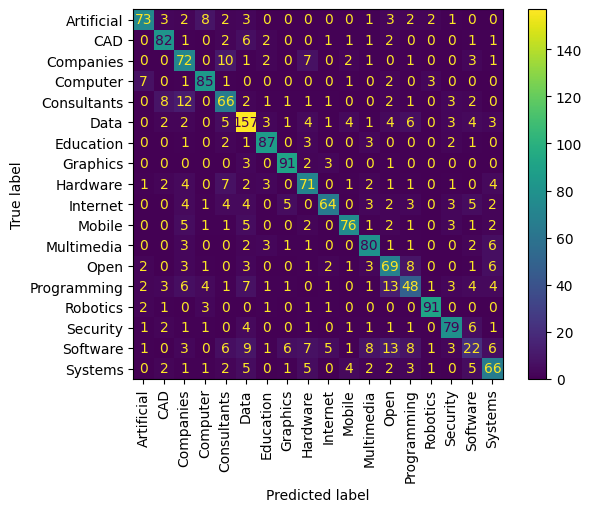

--- 11.053569316864014 seconds ---


In [12]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = str(model) + ' ' + str(vect)
        print(model_label)
        pipe = Pipeline(steps=[
            ('feature_extraction', vect),
            ('model', model)
        ])
        results = get_cls_results(results, model_label, split_data, show_results=True, pipe=pipe)
        print("--- %s seconds ---" % (time.time() - start_time))

In [13]:
results

,Precision,Recall,F1-Score,Time elapsed
RidgeClassifier(random_state=14) TfidfVectorizer(),0.726266,0.729474,0.725400,2.481757
RidgeClassifier(random_state=14) HashingVectorizer(),0.721204,0.725789,0.720443,10.568451
"SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.729040,0.714737,0.719457,15.295589
"SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()",0.704785,0.680526,0.687901,11.729802
SVC(random_state=14) TfidfVectorizer(),0.719627,0.680526,0.687234,15.722584
RidgeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>),0.692132,0.686316,0.686735,12.898492
"SVC(kernel='linear', max_iter=10000, random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)",0.675904,0.672632,0.673130,9.203658
SVC(random_state=14) HashingVectorizer(),0.698400,0.651579,0.660439,14.324294
SVC(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>),0.676713,0.637368,0.642590,13.640335
"LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) TfidfVectorizer()",0.650083,0.632632,0.637902,8.947206


### Preprocessing experiment

Same experiment, but now with some combinations of preprocessing.

In [14]:
pre_processing_pipe_all = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"])),
        ("lemmatizer", LemmatizerTransformer(language="en")),
        ("stemmer", StemmerTransformer(method="porter"))
    ]
)

pre_processing_pipe_stop_lemma = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"])),
        ("lemmatizer", LemmatizerTransformer(language="en"))
    ]
)

pre_processing_pipe_stop_stem = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"])),
        ("stemmer", StemmerTransformer(method="porter"))
    ]
)

pre_processing_pipe_stop_only = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"]))
    ]
)

All Preprocs - SVC(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

  Artificial       0.81      0.63      0.71       100
         CAD       0.86      0.66      0.75       100
   Companies       0.58      0.68      0.63       100
    Computer       0.79      0.77      0.78       100
 Consultants       0.61      0.67      0.64       100
        Data       0.46      0.80      0.59       200
   Education       0.91      0.80      0.85       100
    Graphics       0.90      0.83      0.86       100
    Hardware       0.62      0.57      0.59       100
    Internet       0.80      0.64      0.71       100
      Mobile       0.90      0.72      0.80       100
  Multimedia       0.77      0.65      0.71       100
        Open       0.66      0.69      0.68       100
 Programming       0.45      0.49      0.47       100
    Robotics       0.98      0.86      0.91       100
    Security       0.83      0.53      0.65       10

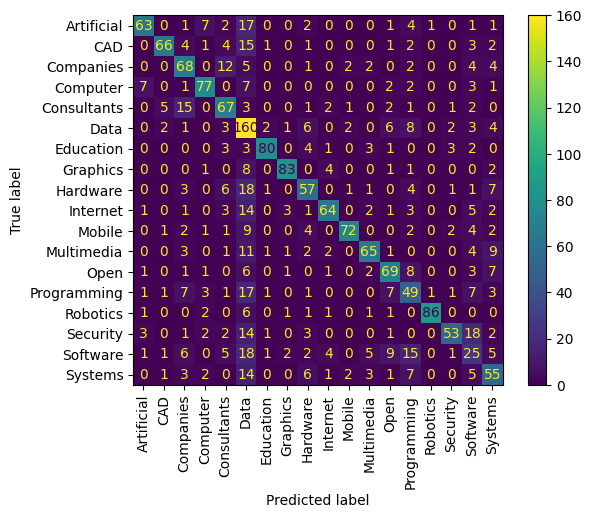

--- 17.78255271911621 seconds ---
All Preprocs - SVC(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

  Artificial       0.83      0.69      0.75       100
         CAD       0.84      0.73      0.78       100
   Companies       0.63      0.66      0.64       100
    Computer       0.79      0.79      0.79       100
 Consultants       0.59      0.66      0.63       100
        Data       0.52      0.83      0.64       200
   Education       0.91      0.81      0.86       100
    Graphics       0.93      0.88      0.90       100
    Hardware       0.72      0.68      0.70       100
    Internet       0.85      0.64      0.73       100
      Mobile       0.90      0.75      0.82       100
  Multimedia       0.86      0.72      0.78       100
        Open       0.68      0.69      0.68       100
 Programming       0.55      0.53      0.54       100
    Robotics       0.97      0.87      0.92       100
    Security       0.80      0.66      0.73    

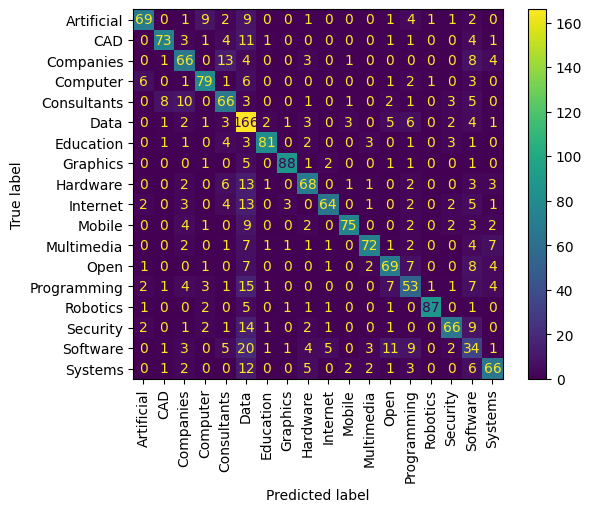

--- 19.586464405059814 seconds ---
All Preprocs - SVC(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

  Artificial       0.82      0.66      0.73       100
         CAD       0.82      0.64      0.72       100
   Companies       0.59      0.66      0.62       100
    Computer       0.78      0.78      0.78       100
 Consultants       0.61      0.66      0.63       100
        Data       0.48      0.82      0.61       200
   Education       0.91      0.79      0.84       100
    Graphics       0.88      0.84      0.86       100
    Hardware       0.66      0.58      0.62       100
    Internet       0.84      0.66      0.74       100
      Mobile       0.91      0.73      0.81       100
  Multimedia       0.80      0.64      0.71       100
        Open       0.68      0.68      0.68       100
 Programming       0.44      0.49      0.46       100
    Robotics       0.97      0.87      0.92       100
    Security       0.78      0.54      0.64 

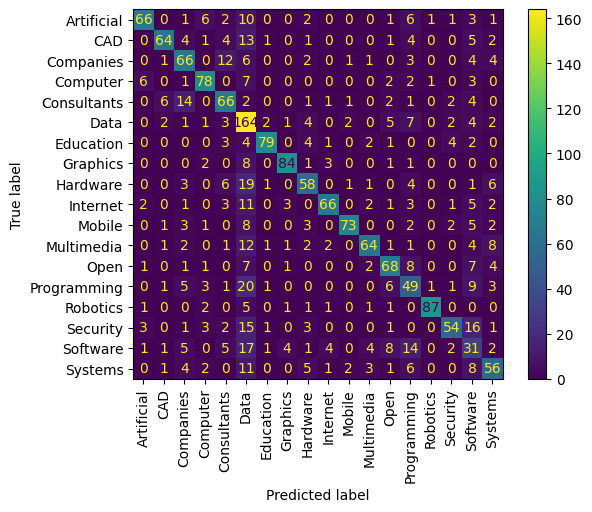

--- 19.96811819076538 seconds ---
All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

  Artificial       0.76      0.68      0.72       100
         CAD       0.77      0.75      0.76       100
   Companies       0.44      0.60      0.51       100
    Computer       0.76      0.77      0.77       100
 Consultants       0.58      0.61      0.60       100
        Data       0.64      0.74      0.69       200
   Education       0.87      0.79      0.83       100
    Graphics       0.92      0.86      0.89       100
    Hardware       0.60      0.61      0.61       100
    Internet       0.66      0.65      0.66       100
      Mobile       0.82      0.75      0.79       100
  Multimedia       0.69      0.63      0.66       100
        Open       0.60      0.67      0.63       100
 Programming       0.49      0.49      0.49       100
    Robotics       0.94      0.88      

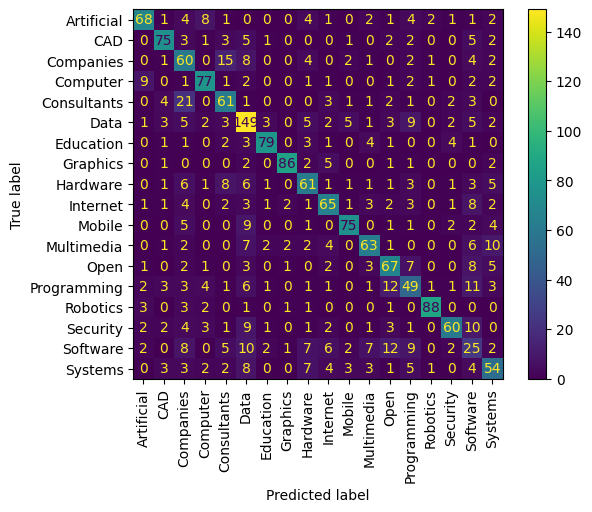

--- 13.850342035293579 seconds ---
All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

  Artificial       0.79      0.74      0.76       100
         CAD       0.82      0.77      0.79       100
   Companies       0.59      0.65      0.62       100
    Computer       0.79      0.81      0.80       100
 Consultants       0.59      0.70      0.64       100
        Data       0.71      0.78      0.74       200
   Education       0.89      0.82      0.85       100
    Graphics       0.92      0.89      0.90       100
    Hardware       0.71      0.72      0.71       100
    Internet       0.78      0.69      0.73       100
      Mobile       0.88      0.76      0.82       100
  Multimedia       0.81      0.72      0.76       100
        Open       0.69      0.70      0.69       100
 Programming       0.53      0.59      0.56       100
    Robotics       0.96      0.89      0.92       100
    Security 

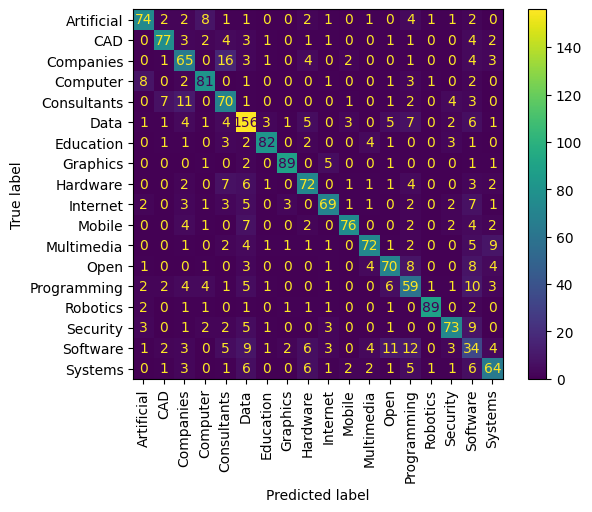

--- 15.55069351196289 seconds ---
All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

  Artificial       0.79      0.68      0.73       100
         CAD       0.81      0.73      0.77       100
   Companies       0.54      0.64      0.59       100
    Computer       0.78      0.76      0.77       100
 Consultants       0.59      0.69      0.64       100
        Data       0.63      0.77      0.70       200
   Education       0.90      0.80      0.85       100
    Graphics       0.91      0.87      0.89       100
    Hardware       0.66      0.63      0.64       100
    Internet       0.74      0.67      0.70       100
      Mobile       0.90      0.74      0.81       100
  Multimedia       0.77      0.70      0.73       100
        Open       0.63      0.66      0.64       100
 Programming       0.43      0.49      0.46       100
    Robotics       0.96      0.89      0.92       100
    Security

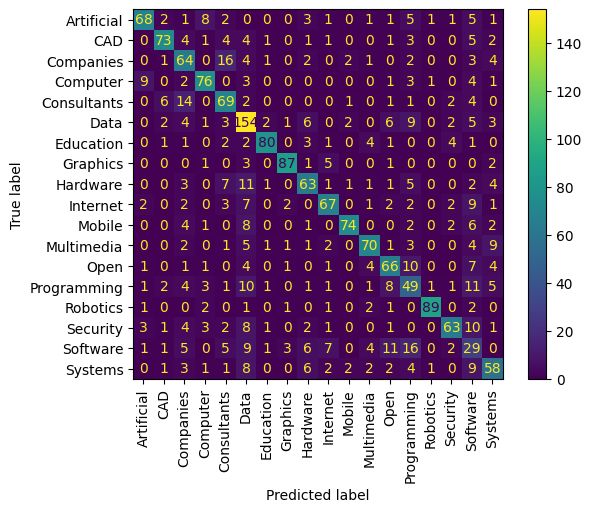

--- 12.83390212059021 seconds ---
All Preprocs - LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

  Artificial       0.74      0.64      0.69       100
         CAD       0.75      0.74      0.74       100
   Companies       0.58      0.63      0.60       100
    Computer       0.75      0.76      0.76       100
 Consultants       0.62      0.59      0.61       100
        Data       0.63      0.73      0.68       200
   Education       0.87      0.78      0.82       100
    Graphics       0.86      0.83      0.85       100
    Hardware       0.58      0.60      0.59       100
    Internet       0.77      0.68      0.72       100
      Mobile       0.78      0.74      0.76       100
  Multimedia       0.69      0.71      0.70       100
        Open       0.61      0.67      0.64       100
 Programming       0.44      0.46      0.45       100
    Robotics       0.96  

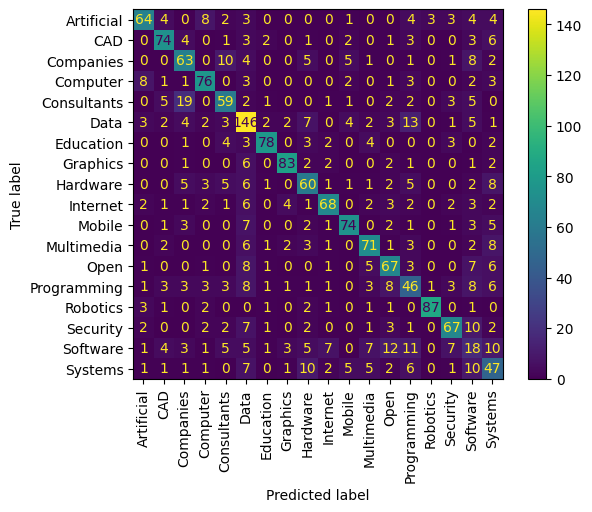

--- 6.039904356002808 seconds ---
All Preprocs - LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) TfidfVectorizer()
              precision    recall  f1-score   support

  Artificial       0.70      0.64      0.67       100
         CAD       0.74      0.64      0.68       100
   Companies       0.60      0.65      0.62       100
    Computer       0.77      0.72      0.74       100
 Consultants       0.65      0.62      0.64       100
        Data       0.58      0.71      0.64       200
   Education       0.88      0.78      0.83       100
    Graphics       0.86      0.82      0.84       100
    Hardware       0.55      0.52      0.54       100
    Internet       0.71      0.66      0.68       100
      Mobile       0.79      0.74      0.76       100
  Multimedia       0.68      0.59      0.63       100
        Open       0.57      0.62      0.60       100
 Programming       0.42      0.44      0.43       100
    Robotics       0.94      0.85      0.89       100


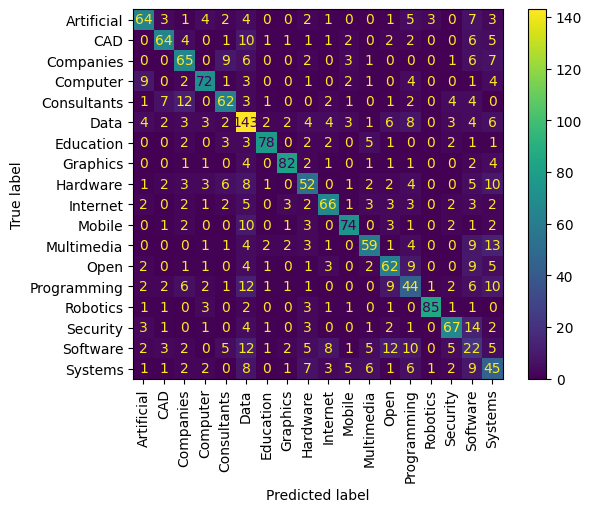

--- 11.818217992782593 seconds ---
All Preprocs - LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) HashingVectorizer()
              precision    recall  f1-score   support

  Artificial       0.72      0.59      0.65       100
         CAD       0.76      0.67      0.71       100
   Companies       0.61      0.64      0.62       100
    Computer       0.75      0.73      0.74       100
 Consultants       0.68      0.59      0.63       100
        Data       0.60      0.72      0.65       200
   Education       0.85      0.76      0.80       100
    Graphics       0.86      0.83      0.84       100
    Hardware       0.60      0.62      0.61       100
    Internet       0.72      0.67      0.69       100
      Mobile       0.79      0.76      0.78       100
  Multimedia       0.69      0.67      0.68       100
        Open       0.59      0.64      0.62       100
 Programming       0.42      0.45      0.43       100
    Robotics       0.93      0.85      0.89       1

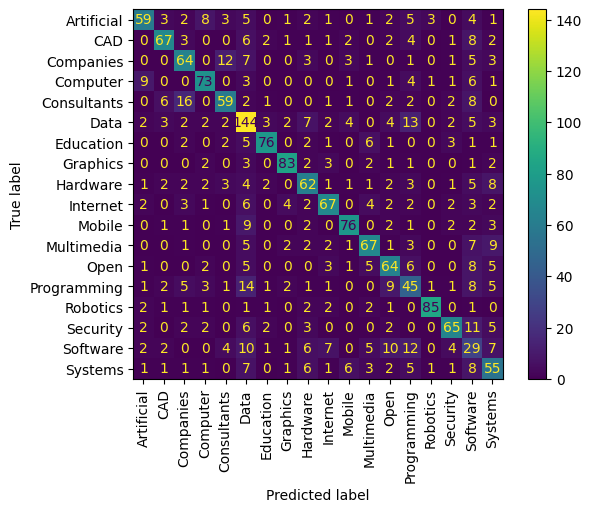

--- 13.59206509590149 seconds ---
All Preprocs - DecisionTreeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

  Artificial       0.66      0.50      0.57       100
         CAD       0.60      0.55      0.57       100
   Companies       0.44      0.47      0.45       100
    Computer       0.68      0.67      0.68       100
 Consultants       0.39      0.44      0.41       100
        Data       0.52      0.55      0.53       200
   Education       0.78      0.66      0.71       100
    Graphics       0.76      0.75      0.75       100
    Hardware       0.38      0.46      0.42       100
    Internet       0.55      0.51      0.53       100
      Mobile       0.68      0.68      0.68       100
  Multimedia       0.49      0.42      0.45       100
        Open       0.55      0.56      0.55       100
 Programming       0.27      0.28      0.28       100
    Robotics       0.90      0.80      0.85       100

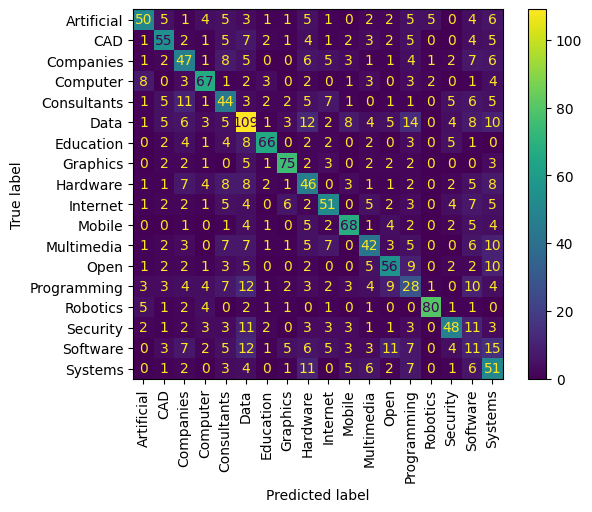

--- 4.376274347305298 seconds ---
All Preprocs - DecisionTreeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

  Artificial       0.58      0.48      0.52       100
         CAD       0.58      0.55      0.56       100
   Companies       0.43      0.53      0.47       100
    Computer       0.56      0.63      0.59       100
 Consultants       0.43      0.46      0.44       100
        Data       0.51      0.52      0.51       200
   Education       0.68      0.68      0.68       100
    Graphics       0.75      0.76      0.76       100
    Hardware       0.44      0.46      0.45       100
    Internet       0.50      0.51      0.50       100
      Mobile       0.69      0.65      0.67       100
  Multimedia       0.45      0.34      0.39       100
        Open       0.52      0.52      0.52       100
 Programming       0.33      0.29      0.31       100
    Robotics       0.88      0.82      0.85       100
    Security       0.58     

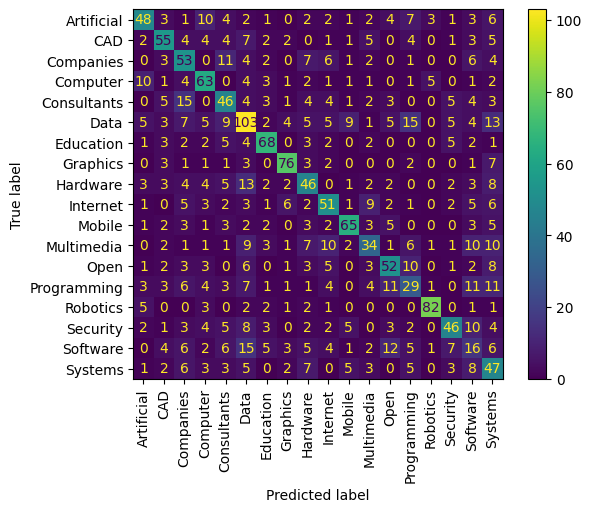

--- 4.864952325820923 seconds ---
All Preprocs - DecisionTreeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

  Artificial       0.57      0.50      0.53       100
         CAD       0.53      0.54      0.54       100
   Companies       0.42      0.45      0.43       100
    Computer       0.67      0.63      0.65       100
 Consultants       0.45      0.47      0.46       100
        Data       0.47      0.55      0.51       200
   Education       0.78      0.67      0.72       100
    Graphics       0.77      0.73      0.75       100
    Hardware       0.33      0.37      0.35       100
    Internet       0.52      0.58      0.55       100
      Mobile       0.67      0.66      0.66       100
  Multimedia       0.53      0.40      0.45       100
        Open       0.59      0.53      0.56       100
 Programming       0.31      0.34      0.32       100
    Robotics       0.83      0.83      0.83       100
    Security       0.64   

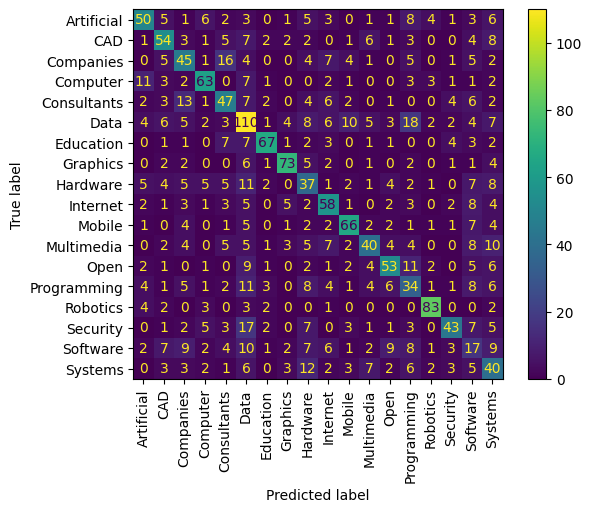

--- 37.89765810966492 seconds ---
All Preprocs - RidgeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

  Artificial       0.80      0.69      0.74       100
         CAD       0.78      0.77      0.77       100
   Companies       0.50      0.67      0.58       100
    Computer       0.70      0.77      0.73       100
 Consultants       0.48      0.59      0.53       100
        Data       0.68      0.72      0.70       200
   Education       0.75      0.78      0.76       100
    Graphics       0.86      0.86      0.86       100
    Hardware       0.61      0.66      0.63       100
    Internet       0.68      0.61      0.64       100
      Mobile       0.83      0.80      0.82       100
  Multimedia       0.73      0.69      0.71       100
        Open       0.59      0.60      0.60       100
 Programming       0.52      0.46      0.49       100
    Robotics       0.96      0.85      0.90       100
    Se

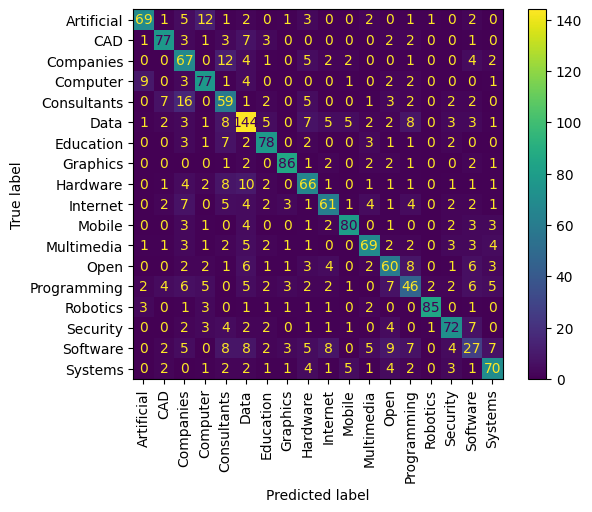

--- 11.165719270706177 seconds ---
All Preprocs - RidgeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

  Artificial       0.80      0.78      0.79       100
         CAD       0.80      0.78      0.79       100
   Companies       0.60      0.70      0.65       100
    Computer       0.73      0.81      0.77       100
 Consultants       0.56      0.64      0.60       100
        Data       0.75      0.80      0.77       200
   Education       0.82      0.83      0.83       100
    Graphics       0.84      0.92      0.88       100
    Hardware       0.68      0.74      0.71       100
    Internet       0.79      0.67      0.72       100
      Mobile       0.82      0.81      0.81       100
  Multimedia       0.78      0.81      0.79       100
        Open       0.61      0.66      0.63       100
 Programming       0.61      0.52      0.56       100
    Robotics       0.91      0.90      0.90       100
    Security       0.79      0.79 

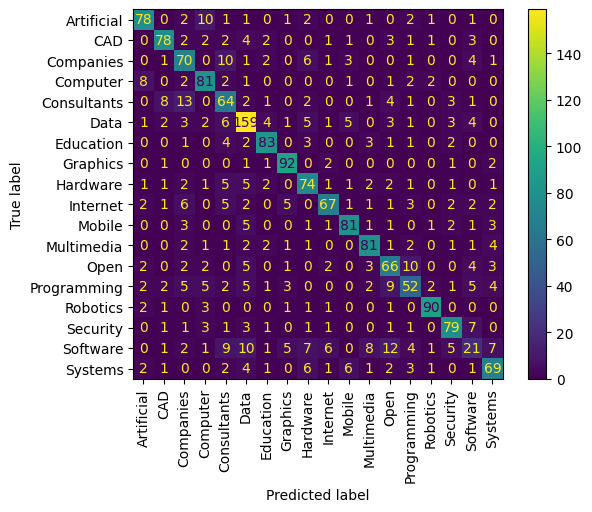

--- 5.100847959518433 seconds ---
All Preprocs - RidgeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

  Artificial       0.77      0.73      0.75       100
         CAD       0.81      0.79      0.80       100
   Companies       0.61      0.69      0.64       100
    Computer       0.76      0.81      0.78       100
 Consultants       0.57      0.65      0.61       100
        Data       0.72      0.79      0.76       200
   Education       0.82      0.82      0.82       100
    Graphics       0.86      0.93      0.89       100
    Hardware       0.64      0.70      0.67       100
    Internet       0.74      0.67      0.71       100
      Mobile       0.81      0.79      0.80       100
  Multimedia       0.76      0.81      0.79       100
        Open       0.59      0.66      0.62       100
 Programming       0.62      0.52      0.57       100
    Robotics       0.93      0.89      0.91       100
    Security       0.78      0.79

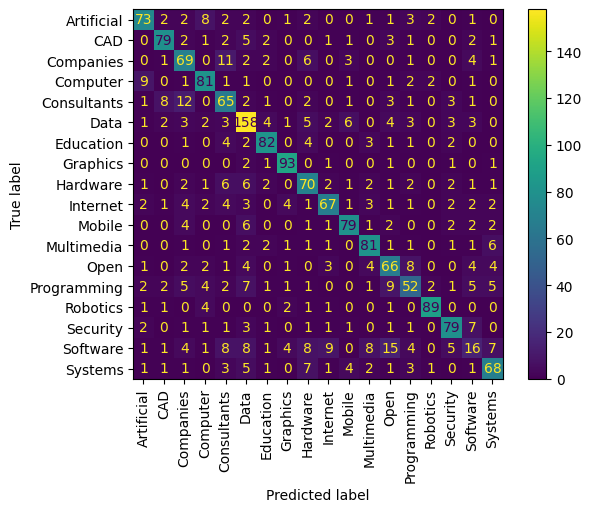

--- 11.063760757446289 seconds ---


In [15]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'All Preprocs - ' + str(model) + ' ' + str(vect)
        print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_all),
                               ('vectorizer', vect),
                               ('model', model)])
        results = get_cls_results(results, model_label, split_data, show_results=True, pipe=pipe)
        print("--- %s seconds ---" % (time.time() - start_time))

In [16]:
results

,Precision,Recall,F1-Score,Time elapsed
"All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.732533,0.722105,0.725801,15.042029
RidgeClassifier(random_state=14) TfidfVectorizer(),0.726266,0.729474,0.725400,2.481757
All Preprocs - RidgeClassifier(random_state=14) TfidfVectorizer(),0.722698,0.728947,0.723292,4.539224
RidgeClassifier(random_state=14) HashingVectorizer(),0.721204,0.725789,0.720443,10.568451
"SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.729040,0.714737,0.719457,15.295589
All Preprocs - RidgeClassifier(random_state=14) HashingVectorizer(),0.711259,0.719474,0.712897,10.390980
All Preprocs - SVC(random_state=14) TfidfVectorizer(),0.731873,0.706316,0.712274,18.921805
"All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()",0.700637,0.683684,0.689166,12.283985
"SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()",0.704785,0.680526,0.687901,11.729802
SVC(random_state=14) TfidfVectorizer(),0.719627,0.680526,0.687234,15.722584


Let's go SVM!!! Despite my personal bias to this model, the best cost-benefit so far looks the Ridge Classifier. Let's compute the other compositions of preprocessing pipelines to discover the winner.

In [17]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'Stopwords and Lemmatization - ' + str(model) + ' ' + str(vect)
        # print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_stop_lemma),
                               ('vectorizer', vect),
                               ('model', model)])
        # for the sake of the reader, here we'll only show the result dataframe
        results = get_cls_results(results, model_label, split_data, show_results=False, pipe=pipe)
        # print("--- %s seconds ---" % (time.time() - start_time))

In [18]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'Stopwords and Stemmer - ' + str(model) + ' ' + str(vect)
        # print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_stop_stem),
                               ('vectorizer', vect),
                               ('model', model)])
        # for the sake of the reader, here we'll only show the result dataframe
        results = get_cls_results(results, model_label, split_data, show_results=False, pipe=pipe)
        # print("--- %s seconds ---" % (time.time() - start_time))

In [19]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'Only Stopwords - ' + str(model) + ' ' + str(vect)
        # print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_stop_only),
                               ('vectorizer', vect),
                               ('model', model)])
        # for the sake of the reader, here we'll only show the result dataframe
        results = get_cls_results(results, model_label, split_data, show_results=False, pipe=pipe)
        # print("--- %s seconds ---" % (time.time() - start_time))

In [20]:
results

,Precision,Recall,F1-Score,Time elapsed
"Only Stopwords - SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.742251,0.727895,0.732591,15.365891
Stopwords and Lemmatization - RidgeClassifier(random_state=14) TfidfVectorizer(),0.725744,0.732632,0.727130,2.341995
"All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.732533,0.722105,0.725801,15.042029
RidgeClassifier(random_state=14) TfidfVectorizer(),0.726266,0.729474,0.725400,2.481757
"Stopwords and Lemmatization - SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.729435,0.721053,0.723708,13.032711
...,...,...,...,...
All Preprocs - DecisionTreeClassifier(random_state=14) HashingVectorizer(),0.528250,0.515789,0.519194,37.439722
All Preprocs - DecisionTreeClassifier(random_state=14) TfidfVectorizer(),0.521996,0.515789,0.516453,4.383727
DecisionTreeClassifier(random_state=14) HashingVectorizer(),0.523944,0.512105,0.516195,26.146846
DecisionTreeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>),0.519075,0.512105,0.513560,1.707065


Our top scorer here was a Linear SVM with stopwords; if we consider the time elapsed as well, the Ridge Classifier with stopwords and lemmatization is the best choice.